In [ ]:
!pip install pandarallel 

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn import metrics
from datetime import datetime
from matplotlib.colors import to_rgba
import holidays
import math
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from datetime import date
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import power_transform

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [340]:
def prediction_stats(y_test,y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',metrics.r2_score(y_test,y_pred))


In [341]:
df_train = pd.read_csv("Train.csv")
df_train['kind'] = 'train'
df_test = pd.read_csv("Test.csv")
df_test['kind'] = 'test'

df = pd.concat([df_train,df_test])
df.head()

/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536
2,2,131.362606,300.613585,398.0,train,2034-04-20 18:57:16,124.000006,313.347763
3,1,143.284351,334.542116,746.0,train,2034-04-28 22:40:52,124.288413,316.495404
4,1,168.709489,363.038196,102.0,train,2034-05-28 11:39:56,177.344861,358.087844


In [342]:
# Convert to datetime 
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [343]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536


In [344]:
df.shape

(1200000, 8)

In [345]:
print(df.isnull().sum())

NumberOfPassengers         0
dropoff_x                  0
dropoff_y                  0
duration              200000
kind                       0
pickup_datetime            0
pickup_x                   0
pickup_y                   0
dtype: int64


## Feature Engineering

### Distance

In [346]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def dist_xy(lon1, lat1, lon2, lat2):
    return np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2 )


In [347]:
df['distance_c'] = dist_xy(df['pickup_x'],df['pickup_y'],df['dropoff_x'],df['dropoff_y'])

# df['distance_h'] = haversine_np(df['pickup_x'],df['pickup_y'],df['dropoff_x'],df['dropoff_y'])

In [348]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501


In [349]:
df.sort_values(by='pickup_datetime')

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c
575938,5,195.192461,389.637719,340.0,train,2034-01-13 00:00:08,189.912678,368.146881,22.129894
511715,5,204.709506,403.076365,708.0,train,2034-01-13 00:00:10,120.972549,320.997441,117.255395
442770,1,220.908590,412.488679,593.0,train,2034-01-13 00:00:52,172.624720,339.391683,87.604241
266217,1,145.111794,322.885412,614.0,train,2034-01-13 00:01:11,153.837420,347.587366,26.197769
276005,1,156.700085,343.560355,94.0,train,2034-01-13 00:01:24,159.031222,346.286065,3.586600
...,...,...,...,...,...,...,...,...,...
100472,2,88.113403,310.808484,NaN,test,2034-07-13 23:58:34,83.323923,333.950905,23.632832
673350,2,173.243260,334.901105,708.0,train,2034-07-13 23:59:02,153.248966,324.205015,22.675497
977278,2,225.339326,425.003268,2122.0,train,2034-07-13 23:59:07,129.091396,442.476968,97.821236
101873,1,77.090423,311.608054,NaN,test,2034-07-13 23:59:15,186.334131,352.355473,116.595626


### Based on dates

In [350]:
# day of the week 
df['dow'] = df['pickup_datetime'].dt.dayofweek

# df['weekend'] = df['dow'].apply(lambda x: 1 if x==0 or x==1 else 0) # not so good 

In [351]:
# week of year
df['woy'] = df['pickup_datetime'].dt.weekofyear

In [352]:
# day of year
df['doy'] = df['pickup_datetime'].dt.dayofyear


In [353]:
# include minutes in time
df['hour'] = df['pickup_datetime'].dt.hour.astype('category')
df['pickup_time'] = df['pickup_datetime'].dt.hour + df['pickup_datetime'].dt.minute/60 


In [354]:
df['weekhour'] = 24*df['dow'] + df['pickup_datetime'].dt.hour + df['pickup_datetime'].dt.minute/60 

In [355]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000


### Holidays

In [359]:
%%time
years = [2034]
custom_holidays = holidays.US(years=years)
for year in years:
    custom_holidays.append({str(year)+"-07-03": "Independence Day Holiday"})
    custom_holidays.append({str(year)+"-04-12": "Easter"})

def is_holiday(x):
    if x.date() in custom_holidays:
        return 1
    return 0

df['is_holiday'] = df['pickup_datetime'].parallel_apply(is_holiday)


CPU times: user 429 ms, sys: 202 ms, total: 631 ms
Wall time: 2.81 s


In [360]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333,0
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000,0


In [521]:
for item in custom_holidays:
    print(custom_holidays[item])

New Year's Day
New Year's Day (Observed)
Martin Luther King, Jr. Day
Washington's Birthday
Memorial Day
Independence Day
Labor Day
Columbus Day
Veterans Day
Veterans Day (Observed)
Thanksgiving
Christmas Day
Independence Day Holiday
Easter


### Passengers

In [361]:
df['NumberOfPassengers'] = df['NumberOfPassengers'].apply(lambda x: 1 if x > 1 else x )

In [362]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333,0
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000,0


### Direction of Travel

In [363]:
%%time 

def direction_lookup(x):
    destination_x = x['dropoff_x']
    origin_x = x['pickup_x']
    destination_y = x['dropoff_y']
    origin_y = x['pickup_y']
    
    deltaX = destination_x - origin_x
    deltaY = destination_y - origin_y
    
    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180
    if degrees_temp < 0:
        degrees_final = 360 + degrees_temp
    else:
        degrees_final = degrees_temp

    compass_brackets = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
    compass_lookup = round(degrees_final / 45)
    return compass_brackets[compass_lookup]

# df['direction_classic'] = df.parallel_apply(direction_lookup, axis=1)

CPU times: user 10 µs, sys: 46 µs, total: 56 µs
Wall time: 59.8 µs


In [364]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333,0
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000,0


### Other option for direction

In [365]:
%%time 

def direction_atan(x):
    destination_x = x['dropoff_x']
    origin_x = x['pickup_x']
    destination_y = x['dropoff_y']
    origin_y = x['pickup_y']
    
    deltaX = destination_x - origin_x
    deltaY = destination_y - origin_y
    
    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180
    if degrees_temp < 0:
        degrees_final = 360 + degrees_temp
    else:
        degrees_final = degrees_temp
    return(degrees_final)

df['direction_angle'] = df.parallel_apply(direction_atan, axis=1)

CPU times: user 6.6 s, sys: 1.2 s, total: 7.8 s
Wall time: 1min 3s


In [366]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday,direction_angle
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333,0,88.375527
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000,0,30.001292


### Season

In [367]:
%%time

def get_season(x):
    if x.month > 2 and x.month < 6:
        return 'Spring'
    elif x.month > 5 and x.month < 9:
        return "Summer"
    elif x.month > 8 and x.month < 12:
        return "Autumn"
    else:
        return 'Winter'
    
df['season'] = df['pickup_datetime'].parallel_apply(get_season)


CPU times: user 443 ms, sys: 172 ms, total: 615 ms
Wall time: 2.62 s


In [368]:
df.head(2)

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday,direction_angle,season
0,1,141.317712,321.357802,434.0,train,2034-06-07 20:47:29,135.428113,321.190773,5.891966,2,23,158,20,20.783333,68.783333,0,88.375527,Summer
1,1,157.145868,337.052655,415.0,train,2034-04-14 08:00:21,148.781291,322.565536,16.728501,4,15,104,8,8.000000,104.000000,0,30.001292,Spring


## Outliers

In [370]:
df['kind'].value_counts()

train    1000000
test      200000
Name: kind, dtype: int64

In [373]:
train_df = df[df['kind'] == 'train']
test_df = df[df['kind'] == 'test']
train_df.shape,test_df.shape

((1000000, 18), (200000, 18))

In [375]:
train_df = train_df[(train_df['duration'] != 0) & (train_df['distance_c'] > 2 )]

In [376]:
train_df.shape

(988591, 18)

In [377]:
train_df['speed'] = (train_df['distance_c'])/(train_df['duration'] /60)

train_df = train_df[train_df['speed'] < 90 ]
train_df = train_df[train_df['speed'] > 1 ]

/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [385]:
train_df.shape

(953213, 19)

In [386]:
print(np.cbrt(train_df['duration']).kurt(),np.cbrt(train_df['duration']).skew())
print(np.log(train_df['duration']).kurt(),np.log(train_df['duration']).skew())
print(pd.DataFrame(boxcox(train_df['duration'])[0]).kurt()[0],pd.DataFrame(boxcox(train_df['duration'])[0]).skew()[0])

0.4394117866088205 0.5568666164084896
0.14842385506792066 -0.18118996391798387
0.028205478575540344 0.0007404221013648376


In [388]:
dat = boxcox(train_df['duration'])
inv_duration = dat[1]
train_df['duration_t'] = dat[0]

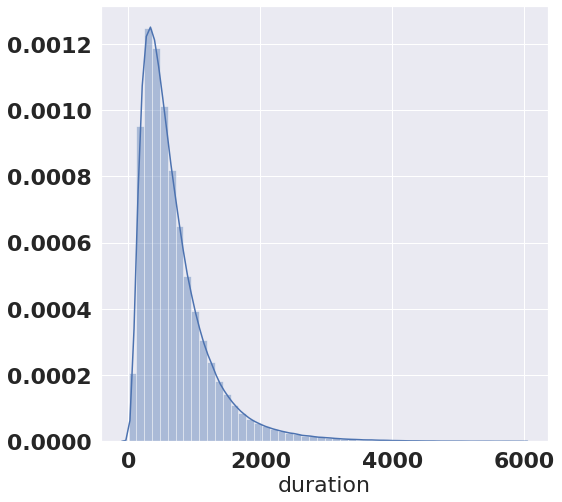

In [513]:
sns.distplot(train_df['duration'])

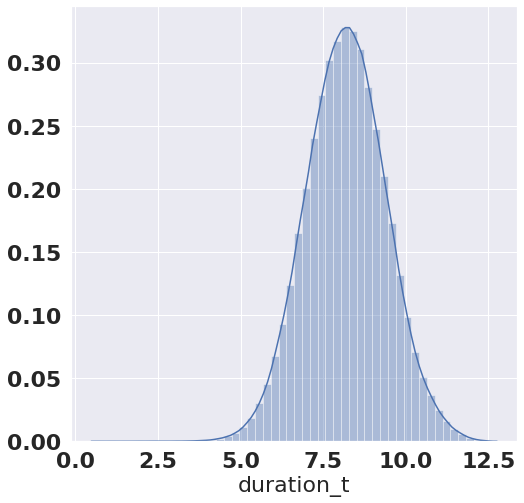

In [514]:
sns.distplot(train_df['duration_t'])

In [390]:
df_new = pd.concat([train_df,test_df])

/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [391]:
df_new['kind'].value_counts()

train    953213
test     200000
Name: kind, dtype: int64

## Transformations

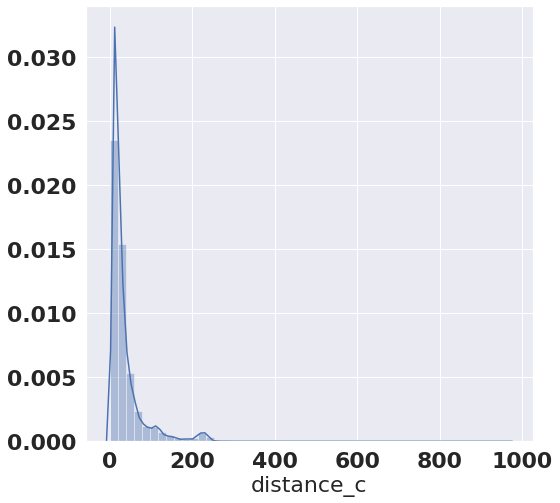

In [515]:
sns.distplot(df['distance_c'])

In [393]:
print(np.cbrt(df['distance_c']).kurt(),np.cbrt(df['distance_c']).skew())
print(np.log(df['distance_c']).kurt(),np.log(df['distance_c']).skew())
print(pd.DataFrame(boxcox(df['distance_c'])[0]).kurt()[0],pd.DataFrame(boxcox(df['distance_c'])[0]).skew()[0])

1.78680803591593 1.189355393328382
1.0674946912312868 0.0153199793888314
1.090325761705564 -0.0013019491383895565


In [394]:
dat = boxcox(df_new['distance_c'])
inv_distance = dat[1]
df_new['distance_t'] = dat[0]

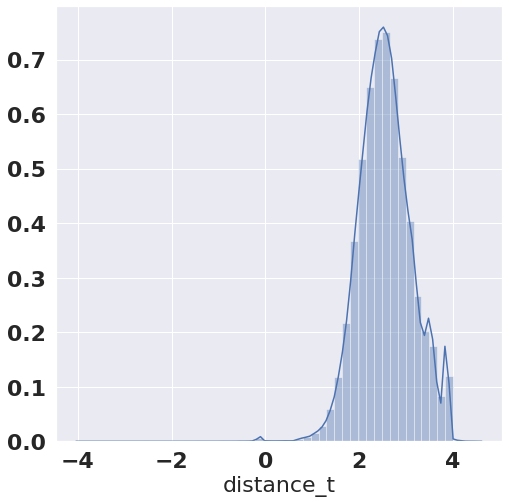

In [517]:
sns.distplot(df_new['distance_t'])

## EDA

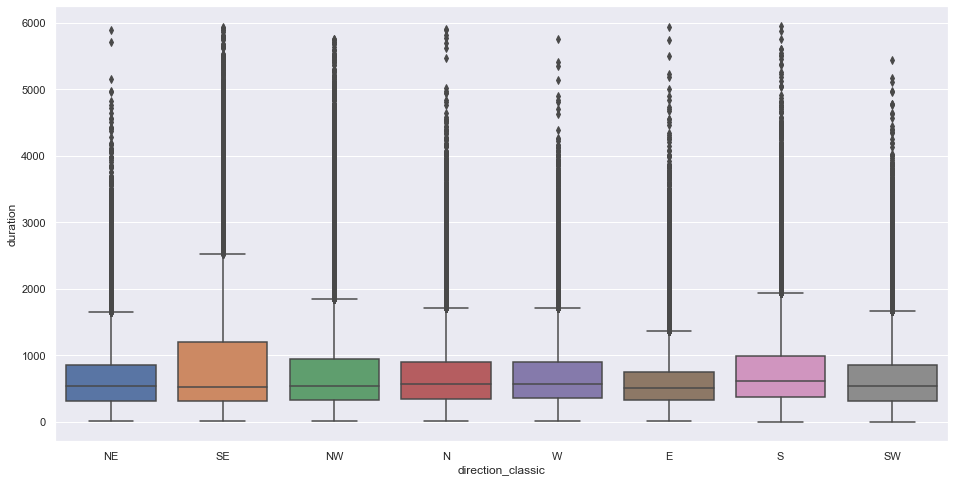

In [56]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(x='direction_classic',y='duration',data=df )

In [323]:
num_vars

['distance_t',
 'pickup_time',
 'pickup_x',
 'pickup_y',
 'dropoff_x',
 'dropoff_y',
 'NumberOfPassengers',
 'direction_angle',
 'weekhour',
 'duration_t']

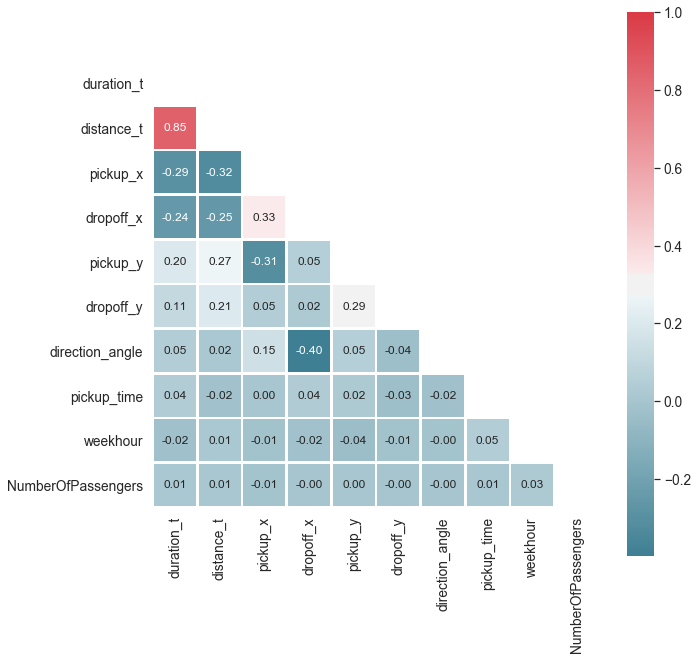

In [324]:
df_new = df[ num_vars ]

sns.set(style="white")
sns.set(rc={'figure.figsize':(10,10)})

def plot_corr_matrix(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    mask = np.zeros_like(corr_abs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c, nr_c))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.set(font_scale=1.25)
    with sns.axes_style("white"):
        sns.heatmap(cm, linewidths=1.5, annot=True, square=True, cmap=cmap,
                    fmt='.2f', annot_kws={'size': 12}, mask=mask,
                    yticklabels=cols.values, xticklabels=cols.values
                   )
    plt.show()
    
plot_corr_matrix(df_new, len(df_new.columns), 'duration_t')


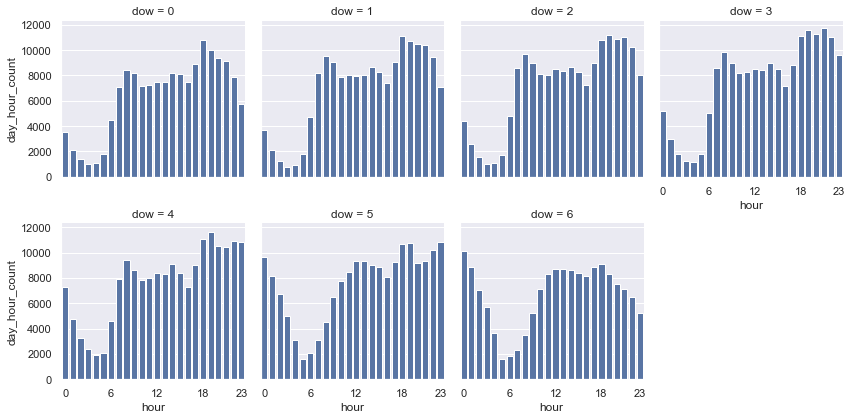

In [482]:
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(data=df.groupby([
    'dow',
    'hour'
]).hour.count().to_frame(name='day_hour_count').reset_index(), col='dow', col_order=range(0,7), col_wrap=4)

g.map(sns.barplot, 'hour', 'day_hour_count');
ticks = ['0','','','','','','6','','','','','','12','','','','','','18','','','','','23']
g.set_xticklabels(ticks)

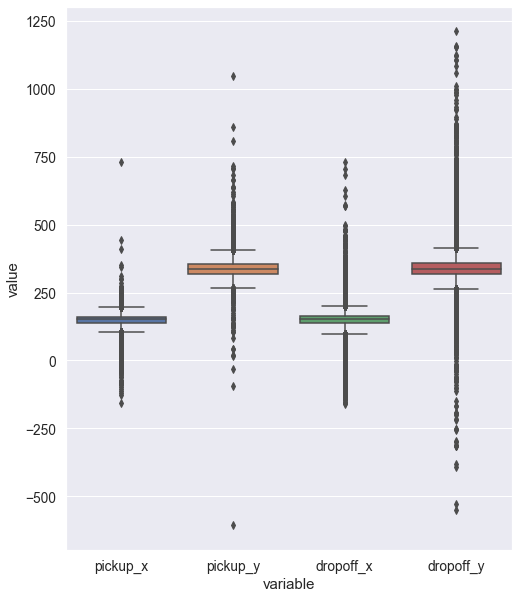

In [160]:
sns.boxplot(x='variable',y='value',data=pd.melt(df[['pickup_x','pickup_y','dropoff_x','dropoff_y']]))

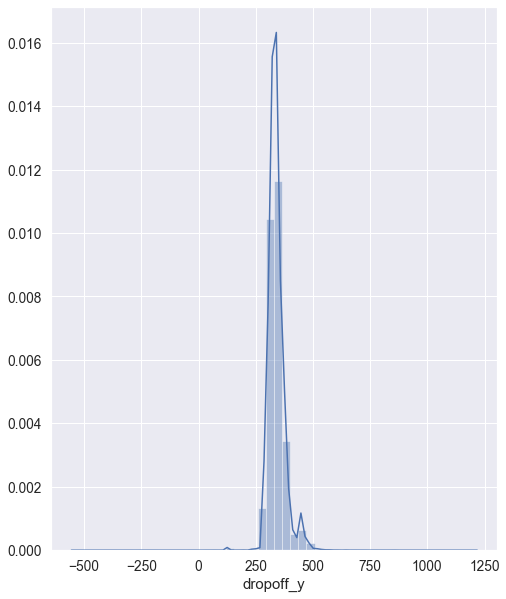

In [164]:
sns.distplot(df['dropoff_y'])

In [ ]:
# sns.set(rc={'figure.figsize':(16,10)})

# for index,line in df[df['speed'] > 10 ].iterrows():
#     plt.plot(line['pickup_x'],line['pickup_y'],'-o',color=to_rgba('blue'))
#     plt.plot(line['dropoff_x'],line['dropoff_y'],'-o',color=to_rgba('red'))


In [ ]:
%%time 

block_size = 100 

a = np.zeros(shape=(31,31))
b = np.zeros(shape=(31,31))
block_count = pd.DataFrame(a,columns=range(-1500,1600,block_size),index=range(-1500,1600,block_size))
block_sum_speed = pd.DataFrame(b,columns=range(-1500,1600,block_size),index=range(-1500,1600,block_size))
points_df = pd.DataFrame(columns=['points','blockspeed'])

def get_blocks(x):
    x1 = x['dropoff_x']
    y1 = x['dropoff_y']
    x2 = x['pickup_x']
    y2 = x['pickup_y']
    distance = x['distance']
    speed = x['speed']
    parts = int(math.ceil(distance/block_size))
    
    def get_base(a):
        if a >= 0:
            return(block_size*math.floor(a/block_size))
        return(block_size*math.ceil(a/block_size))
    
    points = set(zip(  map( get_base, np.linspace(x1, x2, parts+1)), map(get_base,np.linspace(y1,y2, parts+1))))

    for point in points:
        block_count.loc[point[0],point[1]] = block_count.loc[point[0],point[1]] + 1
        block_sum_speed.loc[point[0],point[1]] = block_sum_speed.loc[point[0],point[1]] + speed**speed
     
df[['dropoff_x','dropoff_y','pickup_x','pickup_y','distance','speed']].progress_apply(get_blocks,axis=1)
print()

In [ ]:
avg_speeds = block_sum_speed.div(block_count).fillna(25)

sns.heatmap(avg_speeds)

In [ ]:
avg_speeds = block_sum_speed.div(block_count).fillna(17)

sns.heatmap(avg_speeds)

In [ ]:
%%time 

def get_trip_avg(x):
    x1 = x['dropoff_x']
    y1 = x['dropoff_y']
    x2 = x['pickup_x']
    y2 = x['pickup_y']
    distance = x['distance']
    speed = x['speed']
    parts = int(math.ceil(distance/block_size))
    
    def get_base(a):
        if a >= 0:
            return(block_size*math.floor(a/block_size))
        return(block_size*math.ceil(a/block_size))
    
    points = set(zip(  map( get_base, np.linspace(x1, x2, parts+1)), map(get_base,np.linspace(y1,y2, parts+1))))
    
    return np.max([avg_speeds.loc[item[0],item[1]] for item in points])
    
df['overallspeed'] = df[['dropoff_x','dropoff_y','pickup_x','pickup_y','distance','speed']].parallel_apply(get_trip_avg,axis=1)



In [ ]:
sns.scatterplot(x='speed',y='overallspeed',data=df)

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})

for index,line in df[df['speed'] > 20  ].iterrows():
    plt.scatter(line['pickup_x'],line['pickup_y'],color=to_rgba('blue'))
    plt.scatter(line['dropoff_x'],line['dropoff_y'],color=to_rgba('red'))
    

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})

sns.boxplot(x='direction',y='duration',data=df )

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
sns.scatterplot(x='distance_t',y='duration_t',data=df)

[]

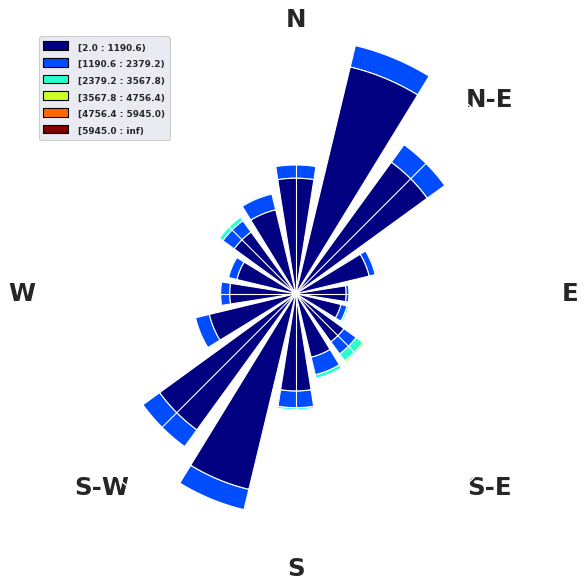

In [512]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables


ws = train_df[train_df['speed']<90]['duration']
wd = train_df[train_df['speed']<90]['direction_angle']

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(loc='upper left',framealpha=1)
ax.tick_params(axis='y', colors='grey')
ax.get_yaxis().set_ticks([])

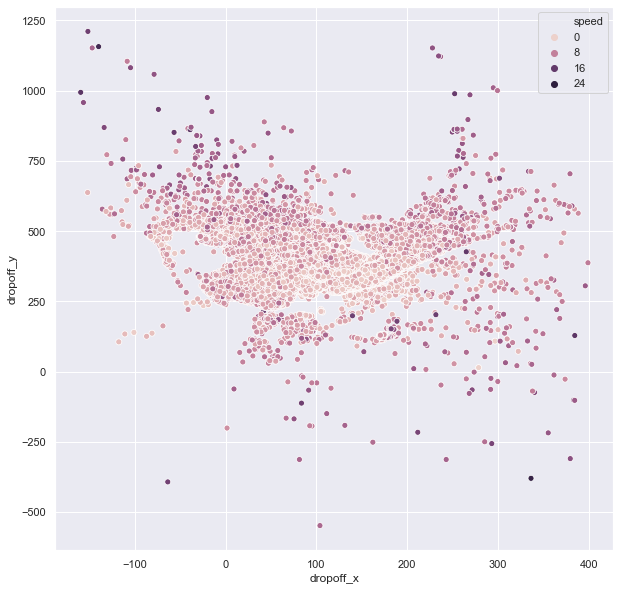

In [496]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x='dropoff_x',y='dropoff_y',data=train_df[( train_df['speed'] < 20) & (train_df['dropoff_x']<400)],hue='speed')

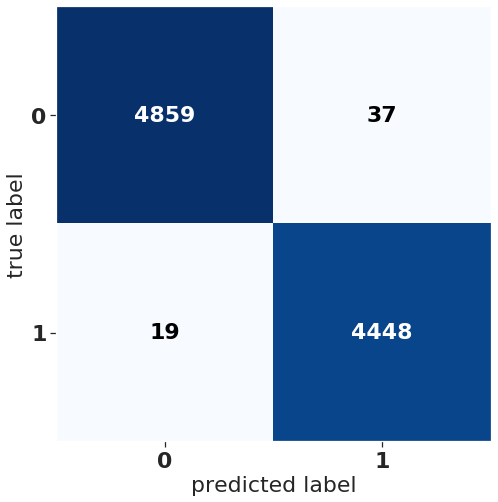

In [510]:
sns.set(rc={'figure.figsize':(8,8)})

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

matplotlib.rc('font', **font)

binary1 = np.array([[4859, 37],
                   [19, 4448]])

plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('axes', labelsize=22)     # fontsize of the axes title

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

plt.set_title('SVM Confusion Matrix')

## Modelling

In [397]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor


In [400]:
df_new.columns

Index(['NumberOfPassengers', 'direction_angle', 'distance_c', 'dow', 'doy', 'dropoff_x', 'dropoff_y', 'duration', 'duration_t', 'hour', 'is_holiday', 'kind', 'pickup_datetime', 'pickup_time', 'pickup_x', 'pickup_y', 'season', 'speed', 'weekhour', 'woy', 'distance_t'], dtype='object')

In [403]:
target = 'duration_t'

cat_vars = ['is_holiday','season','woy','NumberOfPassengers']
num_vars = ['distance_t','pickup_time','pickup_x',
            'pickup_y','dropoff_x','dropoff_y',
            'direction_angle','weekhour']


In [284]:
# # different scaler
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson', standardize=True) 
# txd = pt.fit(df[num_vars])
# calc_lambdas = txd.lambdas_
# print(calc_lambdas)
# txd = pt.transform(df[num_vars])
# df_xt = pd.DataFrame(data=txd, columns=num_vars, index=df.index)

# df_xt.head(2)
# df_dummies = pd.get_dummies(df.loc[:,cat_vars])
# final_df = pd.concat([df_dummies,df_xt],axis=1)

# X = final_df.drop(target,axis=1)
# y = final_df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# output_all = pd.DataFrame()
# output_all['actual'] = np.power(y_test,3)

# final_df.shape

In [293]:
# y_pred_df = pd.concat( [pd.DataFrame(y_pred,index=y_test.index), X_test[list(set(num_vars) - set(['duration'])) ] ],axis=1)
# y_pred_df.columns = num_vars
# y_pred_df.lambdas_ = calc_lambdas

# out = pd.DataFrame(pt.inverse_transform(y_pred_df))

# y_test_df = pd.concat( [y_test, X_test[list(set(num_vars) - set(['duration'])) ] ],axis=1)
# y_test_df.columns = num_vars
# y_test_df.lambdas_ = calc_lambdas

# in_df = pd.DataFrame(pt.inverse_transform(y_test_df))

# prediction_stats(in_df[0],out[0])

In [404]:
df_dummies = pd.get_dummies(df_new.loc[:,cat_vars])

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_new[num_vars]), index=df_new[num_vars].index, columns=df_new[num_vars].columns)

final_df = pd.concat([df_dummies,df_new.loc[:,[target,'kind']],df_scaled],axis=1)


In [405]:
final_df.head()

,is_holiday,woy,NumberOfPassengers,season_Spring,season_Summer,season_Winter,duration_t,kind,distance_t,pickup_time,pickup_x,pickup_y,dropoff_x,dropoff_y,direction_angle,weekhour
1,0,15,1,1,0,0,7.738228,train,-0.369504,-0.946523,0.055962,-0.527083,0.323918,-0.111442,-1.273981,0.350705
2,0,16,1,1,0,0,7.670729,train,-0.527511,0.751121,-0.724165,-0.788143,-0.498568,-1.091803,-0.156774,0.072591
3,0,17,1,1,0,0,8.708691,train,0.161097,1.327338,-0.715086,-0.698997,-0.118265,-0.178986,-1.120629,0.663273
4,0,21,1,1,0,0,5.592037,train,-1.024107,-0.380642,0.955158,0.478954,0.692797,0.587676,1.238855,1.451440
5,0,19,1,1,0,0,7.851364,train,-0.359392,-0.912932,-0.020724,-0.450268,0.336395,-0.088691,-1.166279,0.355323


In [414]:

X = final_df[final_df['kind'] =='train'].drop([target,'kind'],axis=1)
y = final_df[final_df['kind'] =='train'][target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

output_all = pd.DataFrame()

In [415]:
X.head()

,is_holiday,woy,NumberOfPassengers,season_Spring,season_Summer,season_Winter,distance_t,pickup_time,pickup_x,pickup_y,dropoff_x,dropoff_y,direction_angle,weekhour
1,0,15,1,1,0,0,-0.369504,-0.946523,0.055962,-0.527083,0.323918,-0.111442,-1.273981,0.350705
2,0,16,1,1,0,0,-0.527511,0.751121,-0.724165,-0.788143,-0.498568,-1.091803,-0.156774,0.072591
3,0,17,1,1,0,0,0.161097,1.327338,-0.715086,-0.698997,-0.118265,-0.178986,-1.120629,0.663273
4,0,21,1,1,0,0,-1.024107,-0.380642,0.955158,0.478954,0.692797,0.587676,1.238855,1.451440
5,0,19,1,1,0,0,-0.359392,-0.912932,-0.020724,-0.450268,0.336395,-0.088691,-1.166279,0.355323


In [416]:
X.columns

Index(['is_holiday', 'woy', 'NumberOfPassengers', 'season_Spring', 'season_Summer', 'season_Winter', 'distance_t', 'pickup_time', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'direction_angle', 'weekhour'], dtype='object')

In [533]:
%%time


lasso = linear_model.Lasso()
p = {'alpha': [1e-10,1e-5,1e-3,1e-1,1e1,1e3,1e5,2,4,8,64,128]}

lassot = GridSearchCV(
                        lasso, 
                        p, 
                        scoring = 'r2', 
                        cv=10,
                        n_jobs=-1,
                        verbose=2
                    )

if fit:
    lassot.fit(X_train,y_train)
    print(lassot.best_estimator_)

    y_pred = lassot.predict(X_test)

    prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred,inv_duration))
    output_all['dtree'] = inv_boxcox(y_pred,inv_duration)
    

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Mean Absolute Error: 195.62531890485505
Mean Squared Error: 92306.35671117553
Root Mean Squared Error: 303.81961212399625
R2: 0.6878151652334983
CPU times: user 4 s, sys: 1.32 s, total: 5.33 s
Wall time: 1min 11s


Text(0.5, 1.0, 'Feature importance using Lasso Model')

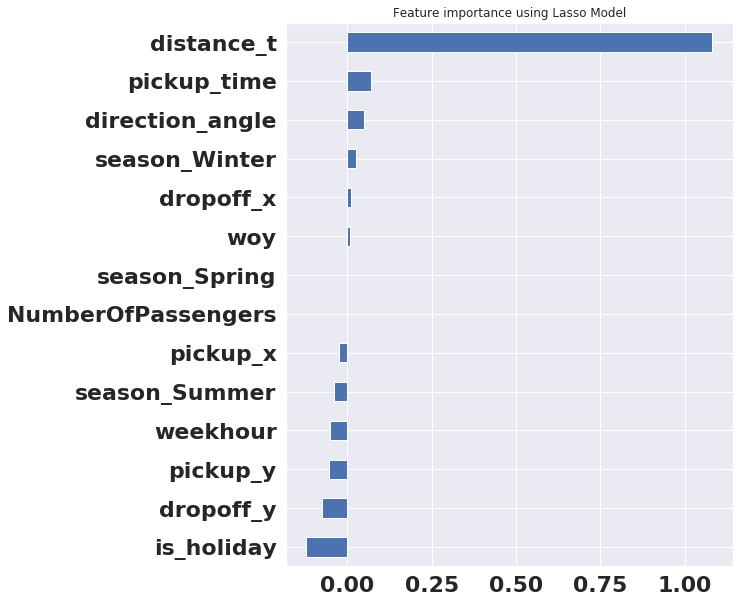

In [534]:
coef = pd.Series(lassot.best_estimator_.coef_, index = X.columns)

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



### Final run

In [421]:
%%time

X_train_final = final_df[final_df['kind'] =='train'].drop([target,'kind'],axis=1)
y_train_final = final_df[final_df['kind'] =='train'][target]
X_test_final = final_df[final_df['kind'] =='test'].drop([target,'kind'],axis=1)

rf2 = RandomForestRegressor(max_depth=27, n_estimators=170,max_features=6,)
rf2.fit(X_train_final, y_train_final)

y_pred_rf2_actual = rf2.predict(X_test_final)


CPU times: user 19min 11s, sys: 21.4 s, total: 19min 32s
Wall time: 19min 43s


In [422]:
final_output = inv_boxcox(y_pred_rf2_actual,inv_duration)

In [424]:
final_output

array([ 446.04549691, 1244.73208915,  915.35311045, ...,  224.32506874,
        132.35913164,  353.74549916])

In [427]:
test_df.tail()

,NumberOfPassengers,dropoff_x,dropoff_y,duration,kind,pickup_datetime,pickup_x,pickup_y,distance_c,dow,woy,doy,hour,pickup_time,weekhour,is_holiday,direction_angle,season
199995,1,158.758340,363.812012,NaN,test,2034-03-31 17:26:40,155.753911,350.638701,13.511577,4,13,90,17,17.433333,113.433333,0,12.847665,Spring
199996,1,148.654715,339.092687,NaN,test,2034-06-19 19:41:56,119.741020,291.134206,56.000158,0,25,170,19,19.683333,19.683333,0,31.085360,Summer
199997,1,140.405926,316.544835,NaN,test,2034-05-30 01:32:59,150.630042,326.450098,14.235406,1,22,150,1,1.533333,25.533333,0,225.907501,Spring
199998,1,171.222134,340.101915,NaN,test,2034-05-06 11:02:58,170.182734,335.313326,4.900096,5,18,126,11,11.033333,131.033333,0,12.246514,Spring
199999,1,159.951649,349.988119,NaN,test,2034-03-08 08:16:39,169.030453,340.742038,12.958191,2,10,67,8,8.266667,56.266667,0,315.523008,Spring


In [437]:
pd.DataFrame(final_output,columns=['duration']).to_csv('G.csv',index=False)

In [431]:
df_out = pd.concat([pd.DataFrame(final_output,columns=['duration']),test_df],axis=1)

In [436]:
df_out.corr()

,duration,NumberOfPassengers,dropoff_x,dropoff_y,duration,pickup_x,pickup_y,distance_c,dow,woy,doy,pickup_time,weekhour,is_holiday,direction_angle
duration,1.000000,0.005432,-0.298290,0.154700,NaN,-0.402604,0.326770,0.868020,-0.034749,0.047476,0.046220,0.032714,-0.030341,0.005117,0.047621
NumberOfPassengers,0.005432,1.000000,0.008536,-0.004036,NaN,0.007310,-0.002944,0.003517,-0.004717,0.001927,0.001751,0.003553,-0.004240,0.001113,-0.003718
dropoff_x,-0.298290,0.008536,1.000000,0.017202,NaN,0.350276,0.041824,-0.323827,-0.023666,-0.001566,-0.002464,0.034476,-0.018992,0.001474,-0.386789
dropoff_y,0.154700,-0.004036,0.017202,1.000000,NaN,0.031958,0.330363,0.270399,-0.008494,0.005348,0.005033,-0.035657,-0.013402,0.003828,-0.035850
duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_x,-0.402604,0.007310,0.350276,0.031958,NaN,1.000000,-0.315636,-0.509341,-0.015612,-0.005548,-0.006147,0.003718,-0.015136,-0.002092,0.145638
pickup_y,0.326770,-0.002944,0.041824,0.330363,NaN,-0.315636,1.000000,0.439648,-0.041408,0.005861,0.004300,0.019976,-0.038761,0.014645,0.050781
distance_c,0.868020,0.003517,-0.323827,0.270399,NaN,-0.509341,0.439648,1.000000,0.005275,0.012456,0.012671,-0.021808,0.002296,0.008482,0.039215
dow,-0.034749,-0.004717,-0.023666,-0.008494,NaN,-0.015612,-0.041408,0.005275,1.000000,-0.052438,-0.014633,-0.084627,0.990623,-0.227076,-0.001437
woy,0.047476,0.001927,-0.001566,0.005348,NaN,-0.005548,0.005861,0.012456,-0.052438,1.000000,0.999285,-0.000802,-0.052665,0.053184,-0.006496


In [418]:
%%time

rf2 = RandomForestRegressor(max_depth=27, n_estimators=170,max_features=6,)
rf2.fit(X_train, y_train)

y_pred_rf2 = rf2.predict(X_test)
prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred_rf2,inv_duration))
output_all['rf'] = inv_boxcox(y_pred_rf2,inv_duration)


Mean Absolute Error: 130.05815035641342
Mean Squared Error: 42546.27908396473
Root Mean Squared Error: 206.26749400708957
R2: 0.8561063010284653
CPU times: user 12min 6s, sys: 12.3 s, total: 12min 18s
Wall time: 12min 23s


In [419]:
output_all['ens'] = (output_all['rf'] + output_all['dtree'])/2

In [420]:
prediction_stats(inv_boxcox(y_test,inv_duration),output_all['ens'])

Mean Absolute Error: 136.1704076521023
Mean Squared Error: 45869.643094985244
Root Mean Squared Error: 214.17199418921524
R2: 0.8448665134167008


Text(0.5, 1.0, 'RF Feature importance')

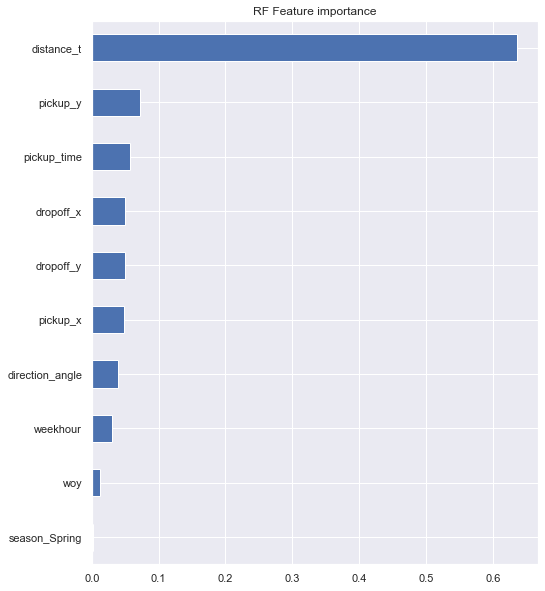

In [491]:
coef = pd.Series(rf2.feature_importances_, index = X.columns)

imp_coef = coef.sort_values().tail(10)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("RF Feature importance")

In [311]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [316]:
%%time 

model = DecisionTreeRegressor(max_depth=60,min_samples_split=170)

sfs = SFS(model, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=2,
         n_jobs=-1)

sfs = sfs.fit(X, y)


CPU times: user 1.59 s, sys: 1.79 s, total: 3.39 s
Wall time: 3min 56s


In [325]:

modelrf = RandomForestRegressor(max_depth=60,min_samples_split=170)

sfsrf = SFS(modelrf, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=2,
         n_jobs=-1)

sfsrf = sfsrf.fit(X, y)



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

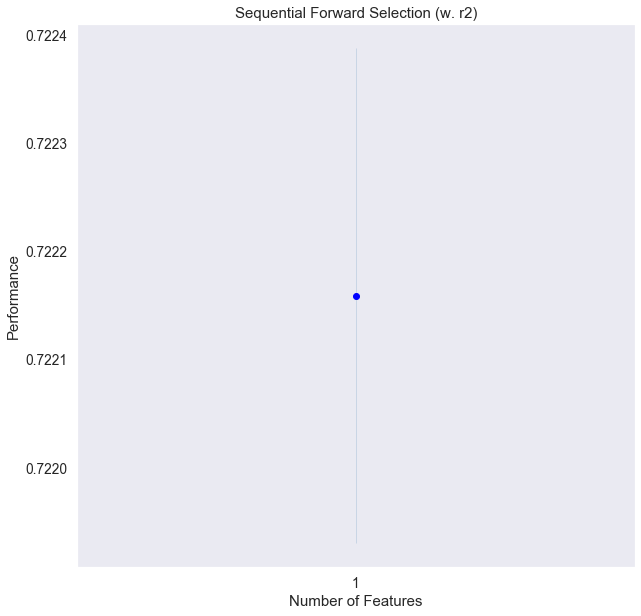

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                          criterion='mse',
                                                          max_depth=60,
                                                          max_features=None,
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=170,
                                                          min_weight_fraction_leaf=0.0,
                                                          presort='deprecated',
                                                          random_state=None

In [329]:
fig = plot_sfs(sfsrf.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. r2)')
plt.grid()
plt.show()
print(sfs)

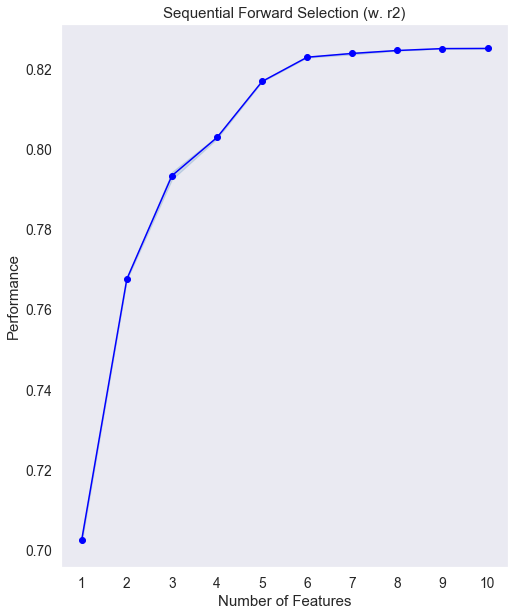

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                          criterion='mse',
                                                          max_depth=60,
                                                          max_features=None,
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=170,
                                                          min_weight_fraction_leaf=0.0,
                                                          presort='deprecated',
                                                          random_state=None

In [318]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. r2)')
plt.grid()
plt.show()
print(sfs)

In [319]:
sfs.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.70187828, 0.70331799]),
  'avg_score': 0.7025981355795712,
  'feature_names': ('distance_t',)},
 2: {'feature_idx': (5, 13),
  'cv_scores': array([0.7673264, 0.7677858]),
  'avg_score': 0.7675560986203847,
  'feature_names': ('distance_t', 'weekhour')},
 3: {'feature_idx': (5, 12, 13),
  'cv_scores': array([0.7923468 , 0.79425534]),
  'avg_score': 0.7933010708212356,
  'feature_names': ('distance_t', 'direction_angle', 'weekhour')},
 4: {'feature_idx': (5, 8, 12, 13),
  'cv_scores': array([0.80250434, 0.80314823]),
  'avg_score': 0.8028262872368599,
  'feature_names': ('distance_t', 'pickup_y', 'direction_angle', 'weekhour')},
 5: {'feature_idx': (5, 6, 8, 12, 13),
  'cv_scores': array([0.81672542, 0.81685665]),
  'avg_score': 0.8167910357971047,
  'feature_names': ('distance_t',
   'pickup_time',
   'pickup_y',
   'direction_angle',
   'weekhour')},
 6: {'feature_idx': (5, 6, 8, 9, 12, 13),
  'cv_scores': array([0.82294206, 0.82272967]

In [288]:
fit = True

In [411]:
%%time
from sklearn.model_selection import KFold, cross_validate

n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True)

model = DecisionTreeRegressor(max_depth=60,min_samples_split=170)
scoring=('r2', 'neg_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring,return_estimator=True)
cv_results


/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'train'

  FitFailedWarning)


CPU times: user 869 ms, sys: 286 ms, total: 1.16 s
Wall time: 1.16 s


/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'train'

  FitFailedWarning)


{'fit_time': array([0.51661992, 0.50619197]),
 'score_time': array([0., 0.]),
 'estimator': (DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=60,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=170,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=60,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=170,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')),
 'test_r2': array([nan, nan]),
 'test_neg_mean_squared_error': array([nan, nan])

In [ ]:
%%time

param_grid = {"max_depth": range(40,100,20),
              'min_samples_split': np.arange(170,200,10)}

param_grid = {"max_depth": [10],
              'min_samples_split': [150]}

# param_grid={}

regressor_dtree = DecisionTreeRegressor()
dtree=GridSearchCV(regressor_dtree,param_grid,cv=5,n_jobs=-1,verbose=2)

if fit:
    dtree.fit(X_train,y_train)
    print(dtree.best_estimator_)

    y_pred = dtree.predict(X_test)

    prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred,inv_duration))
    output_all['dtree'] = inv_boxcox(y_pred,inv_duration)
    
    

In [524]:
%%time

param_grid = {"max_depth": range(40,100,20),
              'min_samples_split': np.arange(170,200,10)}

param_grid = {"max_depth": [10],
              'min_samples_split': [150]}

# param_grid={}

regressor_dtree = DecisionTreeRegressor()
dtree=GridSearchCV(regressor_dtree,param_grid,cv=5,n_jobs=-1,verbose=2)

if fit:
    dtree.fit(X_train,y_train)
    print(dtree.best_estimator_)

    y_pred = dtree.predict(X_test)

    prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred,inv_duration))
    output_all['dtree'] = inv_boxcox(y_pred,inv_duration)
    
    

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=150,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Mean Absolute Error: 163.5083872929225
Mean Squared Error: 63687.52672346944
Root Mean Squared Error: 252.3638776122079
R2: 0.7846055167244368
CPU times: user 7.15 s, sys: 293 ms, total: 7.45 s
Wall time: 16.5 s


Text(0.5, 1.0, 'Dtree Feature importance')

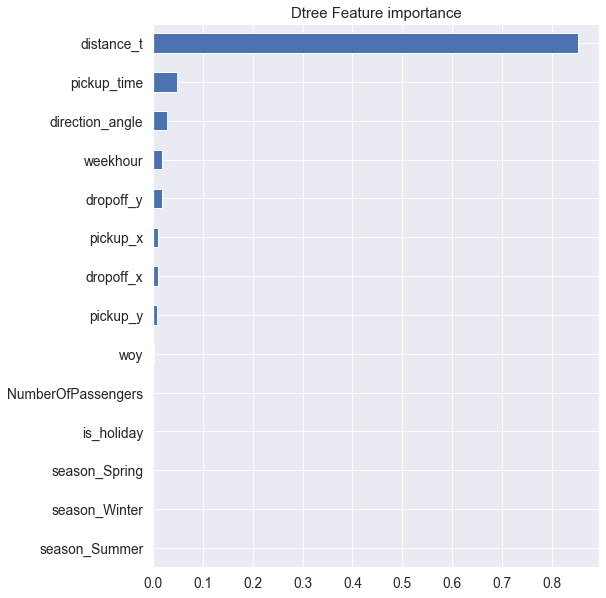

In [291]:
coef = pd.Series(dtree.best_estimator_.feature_importances_, index = X.columns)

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Dtree Feature importance")


In [296]:
from sklearn import model_selection

In [335]:
%%time

rfp = RandomForestRegressor()

param_grid = {
    'max_depth': [25,27],
    'n_estimators': [170],
    'max_features': [7,6,'auto']
}

# param_grid = {
#     'max_depth': [20],
#     'n_estimators': [100],
# }

rf = GridSearchCV(rfp, param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)
if fit:
    rf.fit(X, y)
    print(rf.best_estimator_)
    
#     y_pred = rf.predict(X_test)
    
#     prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred,inv_duration))
#     output_all['rf'] = inv_boxcox(y_pred,inv_duration)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 182.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=170, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
CPU times: user 19min 22s, sys: 15.4 s, total: 19min 37s
Wall time: 3h 22min 22s


In [338]:
%%time

rf2 = RandomForestRegressor(max_depth=27, n_estimators=170,max_features=6,)
rf2.fit(X_train, y_train)

y_pred = rf2.predict(X_test)
prediction_stats(inv_boxcox(y_test,inv_duration),inv_boxcox(y_pred,inv_duration))
output_all['rf'] = inv_boxcox(y_pred,inv_duration)


Mean Absolute Error: 130.21624406323286
Mean Squared Error: 42835.648784192075
Root Mean Squared Error: 206.96774817394152
R2: 0.8555987312360454
CPU times: user 12min 19s, sys: 13.5 s, total: 12min 32s
Wall time: 12min 38s


In [304]:
# %%time

# rfp = RandomForestRegressor(max_features)

# kfold = model_selection.KFold(n_splits=3)
# accuracy_results = model_selection.cross_val_score(rfp, X,y, cv=kfold, scoring='neg_root_mean_squared_error',n_jobs=-1)

# accuracy_results

In [308]:
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True)

model = RandomForestRegressor(max_depth=60,min_samples_split=170)
scoring=('r2', 'neg_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring,return_estimator=True)
cv_results


{'fit_time': array([452.68208909, 444.090698  ]),
 'score_time': array([8.0855248 , 7.37150073]),
 'estimator': (RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=60, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=170, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=60, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=170, min_weight_fraction_leaf=0.0,
          

In [301]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Text(0.5, 1.0, 'RF Feature importance')

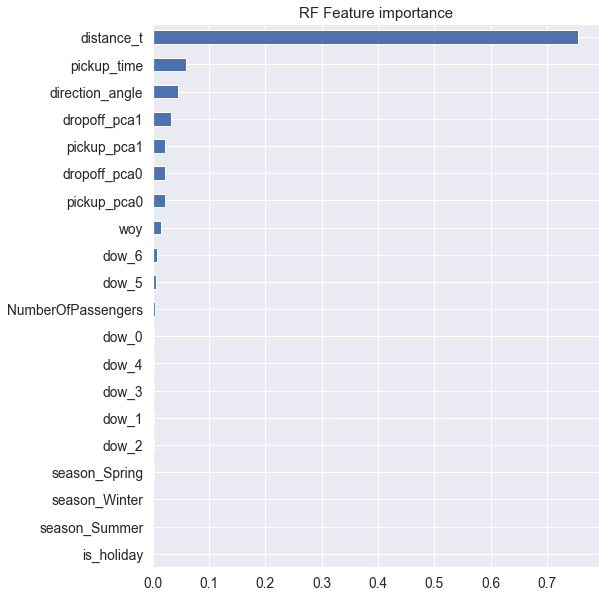

In [188]:
coef = pd.Series(rf.best_estimator_.feature_importances_, index = X.columns)

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("RF Feature importance")


In [522]:
%%time

fit=True

lasso = linear_model.Lasso()
parameters = {'alpha': [1e-5,1e-3,1e-1,1e1,1e3,1e5]}

lasso_regressor = GridSearchCV(
                        lasso, 
                        parameters, 
                        scoring = 'r2', 
                        cv=3,
                        n_jobs=-1,
                        verbose=2
                    )

if fit:
    lasso_regressor.fit(X_train,y_train)

    print(lasso_regressor.best_params_)
    y_pred = lasso_regressor.predict(X_test)

    prediction_stats(np.exp(y_test),np.exp(y_pred))
    output_all['lasso'] = np.exp(y_pred)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    4.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.3s finished


{'alpha': 1e-05}
Mean Absolute Error: 3498.9894255277836
Mean Squared Error: 78971726.46356608
Root Mean Squared Error: 8886.603764294101
R2: 0.5080784404277228
CPU times: user 2.23 s, sys: 647 ms, total: 2.87 s
Wall time: 6.06 s


In [182]:
y_pred_df = pd.concat( [pd.DataFrame(y_pred,index=y_test.index), X_test[list(set(num_vars) - set(['duration'])) ] ],axis=1)
y_pred_df.columns = num_vars
y_pred_df.lambdas_ = calc_lambdas

out = pd.DataFrame(pt.inverse_transform(y_pred_df))

y_test_df = pd.concat( [y_test, X_test[list(set(num_vars) - set(['duration'])) ] ],axis=1)
y_test_df.columns = num_vars
y_test_df.lambdas_ = calc_lambdas

in_df = pd.DataFrame(pt.inverse_transform(y_test_df))

prediction_stats(in_df[0],out[0])

/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


Mean Absolute Error: 196.02460059004852
Mean Squared Error: 93448.33104826695
Root Mean Squared Error: 305.69319758258763
R2: 0.6839529494291416


Text(0.5, 1.0, 'Feature importance using Lasso Model')

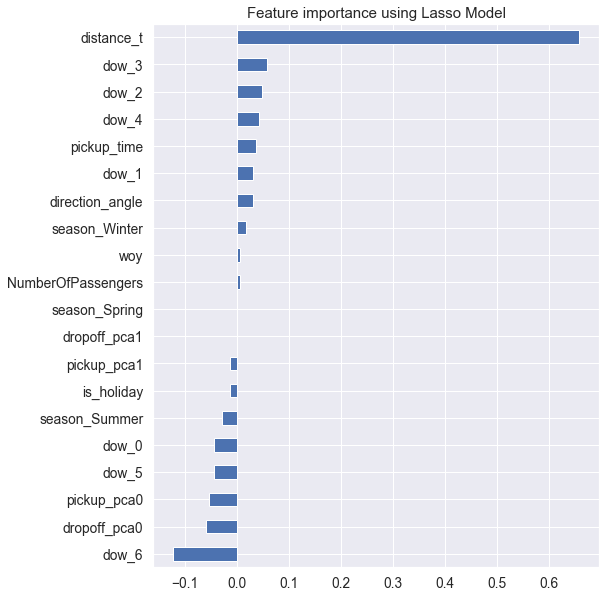

In [191]:
coef = pd.Series(lasso_regressor.best_estimator_.coef_, index = X.columns)

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



In [102]:
fit=True
param_grid = {
    "max_depth": range(3,5,1),
    "n_estimators": range(330,360,5),
    'objective':['reg:squarederror']
    }

param_grid = {}


model_xgb = xgb.XGBRegressor()

xgbr=GridSearchCV(model_xgb,param_grid,cv=3,n_jobs=-1,verbose=2)

if fit:
    xgbr.fit(X_train,y_train)
    print(xgbr.best_estimator_)
    
    y_pred = xgbr.predict(X_test)

    prediction_stats(np.exp(y_test),np.exp(y_pred))
    output_all['xgb'] = np.exp(y_pred)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished
/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
Mean Absolute Error: 29.312078418422058
Mean Squared Error: 1402.4632652330079
Root Mean Squared Error: 37.44947616767166
R2: 0.8179076282208981


Text(0.5, 1.0, 'Feature importance using Lasso Model')

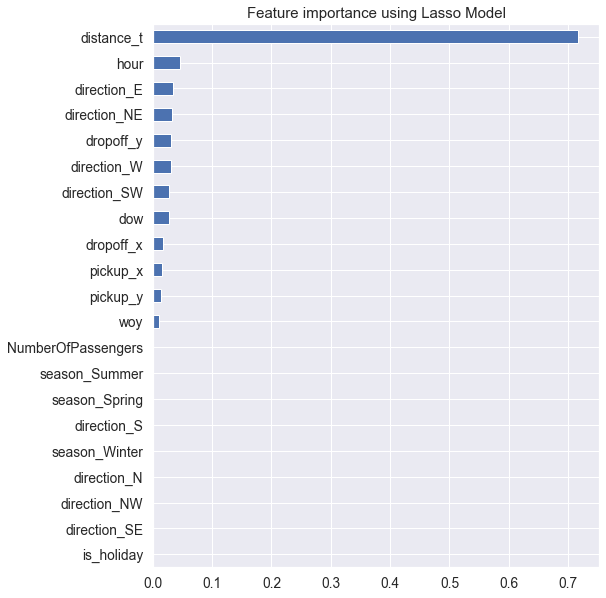

In [104]:
coef = pd.Series(xgbr.best_estimator_.feature_importances_, index = X.columns)

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")



In [1]:
output_all

NameError: name 'output_all' is not defined

In [535]:
from keras import backend
print(backend.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


[]
